In [1]:
import math
import pandas as pd
import torch
from torch import nn
import hashlib
import inspect
import os
import requests
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
import collections
from collections import Counter
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F

# Import necessary plotting tools for inline display
from matplotlib_inline import backend_inline
from IPython import display


In [2]:
print("CUDA available?:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("current CUDA device:", torch.cuda.current_device())

CUDA available?: True
CUDA device count: 1
current CUDA device: 0


# 1. Prepare utilities
###    Directly referenced from "https://d2l.ai/index.html"


In [3]:
# =============================================================================
#  This section includes code adapted from:
#  https://d2l.ai/index.html
#  License: MIT License
#  Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# =============================================================================

In [4]:
class HyperParameters:
    """The base class of hyperparameters.
    
    This class serves as a base for any class that needs to handle hyperparameters.
    It includes methods to save the hyperparameters passed to the class.
    """
    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.
        
        This method saves the arguments passed to the class constructor as attributes of the class.
        It will ignore any attributes passed in the `ignore` list (e.g., 'self' and '_').
        """
        frame = inspect.currentframe().f_back  # Get the previous frame, i.e., the caller of this method
        _, _, _, local_vars = inspect.getargvalues(frame)  # Get local variables from the caller's frame
        # Create a dictionary of the arguments passed to the function (excluding 'self' and those in 'ignore')
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        # Set these arguments as attributes of the current class
        for k, v in self.hparams.items():
            setattr(self, k, v)




class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    This class is used to visualize the progress of some process (e.g., training) by plotting data points.
    It can animate the plot, showing how the data evolves over time. 
    It inherits from `HyperParameters` to save hyperparameters.
    """
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        # Save the hyperparameters (e.g., figure size, axis labels, line styles, colors)
        self.save_hyperparameters()


    def draw(self, x, y, label, every_n=1):
        """This method saves data points and plots the progress.
        
        It stores points for each label, calculates the mean for each series, and displays the plot.
        Points are plotted after every `every_n` steps. 
        The plot updates in real-time.
        
        Args:
            x (float): x-coordinate of the data point.
            y (float): y-coordinate of the data point.
            label (str): Label for the data series.
            every_n (int): Interval between plotting the points. Default is 1, meaning every point is plotted.
        """
        
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):  # Initialize storage for data if it's not already initialized
            self.raw_points = collections.OrderedDict()  # Stores points for each label
            self.data = collections.OrderedDict()  # Stores the mean points for each label
        
        if label not in self.raw_points:  # Initialize empty lists for new labels
            self.raw_points[label] = []
            self.data[label] = []

        points = self.raw_points[label]  # Get the list of points for this label
        line = self.data[label]  # Get the list of mean points for this label

        points.append(Point(x, y))  # Add the current point to the list
        if len(points) != every_n:  # Check if enough points have been accumulated
            return
        
        # Calculate the mean of x and y coordinates for the points collected
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))  # Append the mean point to the line
        points.clear()  # Clear the points list after plotting
        
        if not self.display:  # If display is turned off, do not plot
            return
        
        use_svg_display()  # Use SVG format for better display quality
        if self.fig is None:  
            self.fig = plt.figure(figsize=self.figsize)
        
        plt_lines, labels = [], []  # Prepare lists to store plot lines and their labels
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0]) 
            labels.append(k)  # Add label for this line
        
        axes = self.axes if self.axes else plt.gca()  # Use the provided axes or get the current axes
        if self.xlim: axes.set_xlim(self.xlim)  
        if self.ylim: axes.set_ylim(self.ylim)  
        if not self.xlabel: self.xlabel = self.x  # Use 'x' for x-label if not provided
        axes.set_xlabel(self.xlabel) 
        axes.set_ylabel(self.ylabel) 
        axes.set_xscale(self.xscale)  
        axes.set_yscale(self.yscale) 
        axes.legend(plt_lines, labels) 
        display.display(self.fig)  
        display.clear_output(wait=True)  

In [5]:
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
float32 = torch.float32
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)
randn = torch.randn
expand_dims = lambda x, *args, **kwargs: x.unsqueeze(*args, **kwargs)
concat = torch.cat
nn_Module = nn.Module
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)


def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')


def cpu():
    """Get the CPU device.
    """
    return torch.device('cpu')

def gpu(i=0):
    """Get a GPU device.
    """
    return torch.device(f'cuda:{i}')

def num_gpus():
    """Get the number of available GPUs.
    """
    return torch.cuda.device_count()

def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()




# 2. Download Test Data

In [6]:
# =============================================================================
#  This section includes code adapted from:
#  https://d2l.ai/index.html
#  License: MIT License
#  Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  Modifications made by siriusnbb.
# =============================================================================

In [7]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [8]:
# Download data
def download(url, folder='../data', sha1_hash=None):
    """Download a file from a URL to a specified folder and return the local file path.

    This function handles the downloading of files from the given URL. 
    It saves the file to the specified folder and checks if the file is already present in the cache.
    If the file exists and its hash matches the expected hash, it returns the cached file path. Otherwise, it downloads the file from the URL.
    
    Args:
        url (str): The URL of the file to download.
        folder (str, optional): The folder to save the downloaded file. Defaults to `'../data'`.
        sha1_hash (str, optional): The expected SHA1 hash of the file to verify its integrity. Defaults to `None`.

    Returns:
        str: The local file path to the downloaded file.
    """
    if not url.startswith('http'):
        # For back compatibility with URLs in a data hub dictionary
        url, sha1_hash = DATA_HUB[url]  # Get the URL and SHA1 hash from the data hub if URL is not direct
    
    os.makedirs(folder, exist_ok=True)
    
    # Construct the file name by extracting the file name from the URL
    fname = os.path.join(folder, url.split('/')[-1])
    
    # Check if the file exists in the folder and if a SHA1 hash is provided for verification
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()  # Initialize SHA1 hash object
        with open(fname, 'rb') as f: 
            while True:
                data = f.read(1048576)  # Read the file in chunks of 1 MB
                if not data:
                    break  
                sha1.update(data)  # Update the hash with the data
                
        # If the computed hash matches the expected hash, return the cached file path
        if sha1.hexdigest() == sha1_hash:
            return fname
    
    # If the file does not exist or the hash doesn't match, download the file
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)  # Make an HTTP GET request to download the file
    with open(fname, 'wb') as f:  
        f.write(r.content)  # Write the content of the response to the file
    
    return fname 

def extract(filename, folder=None):
    """Extract a zip or tar file into a specified folder.

    This function extracts the contents of a zip or tar file to the specified folder. 
    If the folder is not provided, it extracts to the same directory where the file is located.
    
    Args:
        filename (str): The path to the zip or tar file to extract.
        folder (str, optional): The folder to extract the contents to. Defaults to `None`, which extracts to the current directory.

    Raises:
        AssertionError: If the file is not a zip or tar file.
    """
    # Get the directory of the file
    base_dir = os.path.dirname(filename)
    
    # Get the file extension
    _, ext = os.path.splitext(filename)
    
    # Check if the file is of supported type (.zip, .tar, .gz)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    
    # Open the file for extraction based on its extension
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')  
    else:
        fp = tarfile.open(filename, 'r')  
    
    # If no folder is provided, set the folder to the base directory of the file
    if folder is None:
        folder = base_dir
    
    # Extract all contents of the file to the specified folder
    fp.extractall(folder)


In [9]:
class Vocab:
    """Vocabulary for text.
    
    This class represents a vocabulary for text processing, which includes a list of tokens (words or characters),
    their frequencies, and mappings between tokens and their indices. 
    It supports indexing tokens, retrieving tokens by their indices, and other operations typical of vocabularies used in NLP tasks.
    """
    
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Initialize the vocabulary with tokens, a minimum frequency, and reserved tokens.

        Args:
            tokens (list, optional): A list of tokens (words or characters) to build the vocabulary. 
                                      Can be a 1D or 2D list of tokens.
            min_freq (int, optional): Minimum frequency of tokens to include in the vocabulary. Tokens that appear
                                      fewer times than this threshold are excluded. Defaults to 0.
            reserved_tokens (list, optional): A list of tokens to always include in the vocabulary (e.g., special tokens like <unk>, <pad>).
                                               Defaults to an empty list.

        """
        # Flatten a 2D list if needed, in case tokens are passed as a list of lists
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        
        # Count the frequency of each token using collections.Counter
        counter = collections.Counter(tokens)
        # Sort the token-frequency pairs in descending order of frequency
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # Create the list of unique tokens including reserved tokens and tokens that meet the min_freq criterion
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        
        # Create a dictionary that maps tokens to indices
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        """Return the number of tokens in the vocabulary."""
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """Retrieve the index for a token or a list/tuple of tokens.
        
        If a single token is passed, returns its index.
        If a list or tuple of tokens is passed,　returns a list of indices for each token.

        Args:
            tokens (str, list, or tuple): A token or a sequence of tokens.
        
        Returns:
            int or list of int: The index of the token or a list of indices for the tokens.
        """
        if not isinstance(tokens, (list, tuple)):
            # Return the index of a single token, or the unknown token's index if not found
            return self.token_to_idx.get(tokens, self.unk)
        # If a list or tuple is passed, return the indices for each token
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """Convert a list or single index back to its corresponding token(s).
        
        If a list of indices is passed, returns the corresponding tokens. 
        If a single index is passed,　returns the corresponding token.
        
        Args:
            indices (int, list, or tuple): A single index or a list/tuple of indices.
        
        Returns:
            str or list of str: The token corresponding to the index or a list of tokens.
        """
        if hasattr(indices, '__len__') and len(indices) > 1:
            # If indices is a list, tuple, or tensor (with length greater than 1), return a list of tokens
            return [self.idx_to_token[int(index)] for index in indices]
        # If it's a single index, return the corresponding token
        return self.idx_to_token[indices]

    '''
        The above check using hasattr(indices, '__len__') checks if indices have a length attribute.
        If they do, it means indices is a list, tuple, or tensor (like a sequence of indices).
        If not, it means it's a single integer index.
        
        len(indices) > 1 checks if the length of indices is greater than 1, meaning it is a list or sequence.
        
        If indices is a list (length > 1) or a tensor (like a multi-dimensional array), the first branch is executed.
        If it is a single index (integer) or a list with length 1, the second branch is executed.
    '''

    @property
    def unk(self):
        """The index for the unknown token ('<unk>').

        Returns:
            int: The index of the '<unk>' token in the vocabulary.
        """
        return self.token_to_idx['<unk>']


In [10]:
# Create the Vocabulary table (vocab)
class MTFraEng(HyperParameters): 

    def __init__(self, batch_size, root='../data', num_workers=4, num_steps=9, num_train=512, num_val=128):
        """Initialize the MTFraEng dataset for English-French translation."""
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        # Build arrays (src and target tokens) and vocabularies for source and target languages
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())
    
    """The English-French dataset."""
    def _download(self):
        """Download and extract the English-French dataset."""
        # Download and extract the 'fra-eng.zip' dataset, and verify the SHA1 hash
        extract(download(DATA_URL+'fra-eng.zip', self.root, '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        # Read the extracted 'fra.txt' file containing English-French sentence pairs
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        """Preprocess the text by replacing non-breaking spaces and inserting spaces between punctuation."""
        # Replace non-breaking space characters with regular spaces
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks like commas, periods, exclamation marks, and question marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
              for i, char in enumerate(text.lower())]  # Convert text to lowercase and handle punctuation spacing
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        """Tokenize the text into source and target sentences."""
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            # If max_examples is specified, break the loop once the specified number of examples is processed
            if max_examples and i > max_examples: break
            parts = line.split('\t')  # Split the sentence pair by tab
            if len(parts) == 2:
                # Add the end-of-sequence token (<eos>) to both source and target sentences
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt  # Return tokenized source and target sentences
        
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        """Convert the raw text into tensor arrays and build vocabularies."""
        def _build_array(sentences, vocab, is_tgt=False):
            """Helper function to build an array from sentences with padding and trimming."""
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))  # Pad or trim the sequence to fixed length
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]  # Apply padding or trimming
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]  # Add the beginning-of-sequence token (<bos>) to target sentences
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)  # Build vocabulary with minimum frequency of 2 for each token
            array = torch.tensor([vocab[s] for s in sentences])  # Convert sentences to tensor using the vocabulary
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)  # Calculate valid length (excluding padding)
            return array, vocab, valid_len  # Return the array, vocabulary, and valid lengths
        
        # Tokenize the raw text into source and target sentences
        src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
        
        # Build arrays for source and target sentences
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        
        # Return the processed arrays and vocabularies
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab)
        
    def get_dataloader(self, train):
        """Return the data loader for training or validation."""
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)  # Get the appropriate data slice
        return self.get_tensorloader(self.arrays, train, idx)  # Get the data loader using the tensor data

    def train_dataloader(self):
        """Return the training dataloader.
        
        This is a convenience method that calls `get_dataloader(train=True)` to get the training data loader.
        """
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        """Return the validation dataloader.
        
        This is a convenience method that calls `get_dataloader(train=False)` to get the validation data loader.
        """
        return self.get_dataloader(train=False)


    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Create a DataLoader using PyTorch's DataLoader from given tensors.
        
        This function creates a `DataLoader` using PyTorch's `TensorDataset` and `DataLoader` to replace MXNet's Gluon.
        It takes tensors and converts them into batches for training or validation.
        
        Args:
            tensors (tuple): A tuple of tensors (e.g., input data, labels).
            train (bool): Whether to shuffle the data for training. If `False`, it is for validation.
            indices (slice): A slice object to select which subset of the data to use. Default is all data.
        
        Returns:
            DataLoader: A PyTorch DataLoader that can be used to load data in batches.
        """
        tensors = tuple(
            a[indices].clone().detach() if isinstance(a, torch.Tensor) else torch.tensor(a[indices])
            for a in tensors
        )
    
        dataset = TensorDataset(*tensors)  # Create a TensorDataset from the tensors
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=train)

    def build(self, src_sentences, tgt_sentences):
        """Build the data arrays from source and target sentences."""
        # Combine the source and target sentences into raw text
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(src_sentences, tgt_sentences)])
        # Build the arrays for the raw text and return them
        arrays, _, _ = self._build_arrays(raw_text, self.src_vocab, self.tgt_vocab)
        return arrays


# 3. Basic functions for Transformer

In [11]:
# =============================================================================
#  This section includes code adapted from:
#  https://d2l.ai/index.html
#  License: MIT License
#  Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  Modifications made by siriusnbb.
# =============================================================================

## (1) Embedding

In [12]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        """
        Args:
            vocab_size: size of vocabulary (all vacabulary)
            embedding_dim: target dimension of embeddings
        """
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

## (2) Positional encoding

In [13]:
class Positional_Embedding(nn.Module):
    def __init__(self, max_seq_len, embed_dim, dropout):
        """
        This layer computes positional encodings that will be added to the input embeddings to provide information about the position of each token in the sequence.
       
        Args:
            max_seq_len (int): The maximum length of input sequences.
            embed_dim (int): The dimension of the embedding vector.
            dropout (float): Dropout rate to apply after adding the positional encoding.

        """
        super().__init__()
        self.embedding_dim = embed_dim  
        self.dropout = nn.Dropout(dropout)  # Create a dropout layer

        # Initialize the positional encoding matrix with zeros
        p_matrix = torch.zeros(max_seq_len, self.embedding_dim)

        # Compute the positional encodings using sine and cosine functions
        for pos in range(max_seq_len):  
            for i in range(0, self.embedding_dim, 2):  # Iterate over the embedding dimensions with step 2
                # Even indices (sine function)
                p_matrix[pos, i] = math.sin(pos / (10000 ** ((2 * i) / self.embedding_dim)))
                # Odd indices (cosine function)
                p_matrix[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / self.embedding_dim)))

        # The positional encoding matrix (p_matrix) is initially of shape (max_seq_len, embed_dim).
        # Unsqueeze the first dimension to add a batch dimension (1, max_seq_len, embed_dim)
        # This allows broadcasting during addition with input embeddings.
        p_matrix = p_matrix.unsqueeze(0)

        # Register the positional encoding matrix as a buffer (non-trainable parameter)
        # This allows the matrix to be moved to the correct device (CPU/GPU) automatically when calling cuda() or to(device).
        self.register_buffer('p_matrix', p_matrix)

    def forward(self, x):
        """
        Forward pass for adding positional encodings to input embeddings.

        Args:
            x (Tensor): The input tensor of shape (batch_size, seq_len, embed_dim) representing embedded tokens.

        Returns:
            Tensor: The output tensor of the same shape as input, but with added positional encoding.
        """
        # Scale the input embeddings by the square root of the embedding dimension
        x = x * math.sqrt(self.embedding_dim)

        # Get the sequence length from the input tensor
        seq_len = x.size(1)

        # Add the positional encoding to the input embeddings
        # Slice the positional encoding matrix to match the sequence length of the input
        # We use torch.autograd.Variable with requires_grad=False to ensure the positional encoding is not updated during backpropagation
        x = x + torch.autograd.Variable(self.p_matrix[:, :seq_len], requires_grad=False)

        # Apply dropout to the resulting embeddings
        return self.dropout(x)


## (3) Multihead attention

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_hiddens, heads_num, dropout, bias=False, **kwargs):
        """
        Initialize the MultiHeadAttention layer.

        Args:
            num_hiddens (int): The dimension of the embedding (output of the embedding layer).
            heads_num (int): The number of attention heads.
            dropout (float): Dropout rate to apply to the attention weights.
            bias (bool, optional): Whether to use bias terms in the linear layers. Defaults to False.
        """
        super().__init__()

        # Ensure that the dimension of the hidden layer can be evenly divided by the number of heads.
        assert num_hiddens % heads_num == 0, "num_hiddens must be divisible by heads_num"
        
        # Store the number of hidden units (embedding dimension) and the number of attention heads
        self.num_hiddens = num_hiddens  # e.g., 256
        self.heads_num = heads_num  # e.g., 4
        self.single_head_dim = int(self.num_hiddens / self.heads_num)  # e.g., 64 (each head's key/query/value dimension)

        # Define the learnable matrices for the query, key, and value projections
        # These are Linear layers that project the input into query, key, and value matrices.
        self.W_q = nn.Linear(self.num_hiddens, self.num_hiddens, bias=False)  # Query transformation matrix
        self.W_k = nn.Linear(self.num_hiddens, self.num_hiddens, bias=False)  # Key transformation matrix
        self.W_v = nn.Linear(self.num_hiddens, self.num_hiddens, bias=False)  # Value transformation matrix
        
        # Output transformation matrix to combine all attention heads
        self.W_out = nn.Linear(self.num_hiddens, self.num_hiddens)

        # Dropout layer to apply after softmax on the attention weights
        self.dropout = nn.Dropout(dropout)

    def transpose_qkv(self, X):
        """Transpose the query, key, or value tensor for parallel computation of multiple attention heads."""
        
        # Input X has shape:
        # For query, key, value: (batch_size, seq_len, num_hiddens)

        # Reshape the input to separate attention heads
        X = X.reshape(X.shape[0], X.shape[1], self.heads_num, -1)  # Reshape to (batch_size, seq_len, heads_num, head_dim)

        # Transpose to arrange the dimensions as (batch_size, heads_num, seq_len, head_dim)
        X = X.permute(0, 2, 1, 3)  # (batch_size, heads_num, seq_len, head_dim)

        
        return X  # (batch_size， heads_num, seq_len, head_dim)

    def forward(self, queries, keys, values, valid_lens):
        """
        Args:
            keys (Tensor): Input tensor of keys with shape (batch_size, seq_len, num_hiddens).
            queries (Tensor): Input tensor of queries with shape (batch_size, seq_len, num_hiddens).
            values (Tensor): Input tensor of values with shape (batch_size, seq_len, num_hiddens).
            valid_lens (Tensor, optional): A tensor representing valid lengths for masking purposes.
        
        Returns:
            output (Tensor): The attention output tensor with shape (batch_size, seq_len, num_hiddens).
            attention_weights (Tensor): The attention weights with shape (batch_size, heads_num, seq_len, seq_len).
        """
        batch_size, seq_len, _ = queries.shape  # Get batch size and sequence length

        # Compute query, key, and value projections
        queries = self.transpose_qkv(self.W_q(queries))  # Shape: (batch_size, heads_num, seq_len, head_dim)
        keys = self.transpose_qkv(self.W_k(keys))      # Shape: (batch_size, heads_num, seq_len, head_dim)
        values = self.transpose_qkv(self.W_v(values))  # Shape: (batch_size, heads_num, seq_len, head_dim)

        # Adjust keys by transposing the last two dimensions for matrix multiplication
        keys_adjusted = keys.transpose(-1, -2)  # Shape: (batch_size, heads_num, head_dim, seq_len)

        # Compute the attention scores (dot product between queries and keys)
        product = torch.matmul(queries, keys_adjusted)  # Shape: (batch_size, heads_num, seq_len, seq_len)

        # Apply the mask if valid_lens is provided
        if valid_lens is not None:
            product_shape = product.shape  
            
            # Generate a mask from valid_lens
            if valid_lens.dim() == 1:
                valid_lens = torch.repeat_interleave(valid_lens, product_shape[1] * product_shape[2], dim=0)
            else:
                valid_lens = torch.repeat_interleave(valid_lens, product_shape[1], dim=0)
                valid_lens = valid_lens.reshape(-1)

            # Reshape the product tensor and apply the mask
            product = product.reshape(-1, product_shape[-1])
            
            # Get the maximum sequence length
            maxlen = product.size(1)
            
            # Create a mask to block out invalid positions
            mask = torch.arange(maxlen, dtype=torch.float32, device=product.device)[None, :] < valid_lens[:, None]
            product[~mask] = -1e6  

            # Reshape the product tensor back to its original shape
            product = product.reshape(product_shape)

        # Scale the attention scores by the square root of the head dimension
        product = product / math.sqrt(self.single_head_dim)

        # Apply softmax to the attention scores to get attention weights
        attention_weights = F.softmax(product, dim=-1)

        attention_weights = self.dropout(attention_weights)  # Apply dropout to the attention weights
        self.attention_weights = attention_weights

        
        # Multiply the attention weights with the value matrix to get the output
        output = torch.matmul(attention_weights, values)  # Shape: (batch_size, heads_num, seq_len, head_dim)

        # Concatenate the outputs from all attention heads
        concat = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.single_head_dim * self.heads_num)

        # Apply the final output linear transformation
        output = self.W_out(concat)  # Shape: (batch_size, seq_len, num_hiddens)

        return output, attention_weights


## (4) Position Wise Feed Forward Net

In [15]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        
        self.ffn = nn.Sequential(
                nn.LazyLinear(ffn_num_hiddens),
                nn.ReLU(),
                nn.LazyLinear(ffn_num_outputs))

    def forward(self, X):
        return self.ffn(X)

## (5) AddNorm

In [16]:
class AddNorm(nn.Module):  
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

# 4. Transformer

In [17]:
# =============================================================================
#  This section includes code adapted from:
#  https://d2l.ai/index.html
#  License: MIT License
#  Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  Modifications made by siriusnbb.
# =============================================================================

## (1) Encoder Block 

In [18]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, heads_num, dropout, use_bias=False):
        """
        Initialize the Transformer Encoder block.

        Args:
            num_hiddens (int): The dimension of the embedding (input/output size of the block).
            ffn_num_hiddens (int): The hidden dimension of the Feed-Forward Network (FFN).
            heads_num (int): The number of attention heads in the Multi-Head Attention mechanism.
            dropout (float): The dropout rate to prevent overfitting.
            use_bias (bool): Whether to use bias in the attention mechanism (default is False).
        """
        super().__init__()

        # MultiHeadAttention: This component computes the self-attention scores for the input sequence.
        self.attention = MultiHeadAttention(num_hiddens, heads_num, dropout, use_bias) # Attention layer (256)
        
        # AddNorm1: This layer applies residual connection and normalization after attention.
        self.addnorm1 = AddNorm(num_hiddens, dropout)  
        
        # Feed-Forward Network (FFN): This is a position-wise feed-forward network that operates on each token.
        # It has a hidden layer with `ffn_num_hiddens` units and outputs a tensor with dimension `num_hiddens`.
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens) 
        
        # AddNorm2: This layer applies residual connection and normalization after the FFN.
        self.addnorm2 = AddNorm(num_hiddens, dropout)  # AddNorm after FFN 

    def forward(self, X, valid_lens):
        """
        Forward pass through the Transformer Encoder block.

        Args:
            X (Tensor): Input tensor with shape (batch_size, seq_len, num_hiddens) representing the embedded tokens.
            valid_lens (Tensor): A tensor of valid sequence lengths for masking the attention scores.

        Returns:
            Tensor: The output of the encoder block with shape (batch_size, seq_len, num_hiddens).
        """
        # Compute the self-attention output
        attn_output, _ = self.attention(X, X, X, valid_lens)  # Multi-head self-attention
        
        # Add normalization and residual connection after attention
        Y = self.addnorm1(X, attn_output)  # Apply AddNorm after attention
        
        # Apply the Feed-Forward Network (FFN) and then apply AddNorm after FFN
        return self.addnorm2(Y, self.ffn(Y))  # Apply AddNorm after FFN



## (2) Transformer Encoder

In [19]:
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder class.

    Args:
        vocab_size (int): The size of the vocabulary (number of unique tokens in the input).
        max_seq_len (int): The maximum length of the input sequence.
        embedding_dim (int): The dimension of the embedding vectors (output size of the embedding layer).
        num_blk_layers (int): The number of encoder layers (TransformerEncoderBlock).
        ffn_num_hiddens (int): The dimension of the hidden layer in the Feed-Forward Network (FFN).
        heads_num (int): The number of heads in the Multi-Head Attention mechanism.
        dropout (float): The dropout rate to apply to the layers for regularization.

    Returns:
        out (Tensor): The output of the encoder with shape (batch_size, seq_len, embedding_dim).
    """
    def __init__(self, vocab_size, max_seq_len, embedding_dim, num_blk_layers, ffn_num_hiddens, heads_num, dropout):
        super().__init__()
        
        # Initialize the embedding layer that maps input tokens to their embedding vectors
        self.embedding = Embedding(vocab_size, embedding_dim)
        
        # Initialize the positional encoding layer to add position information to the embeddings
        self.positional_encoder = Positional_Embedding(max_seq_len, embedding_dim, dropout)
        
        # Initialize the stack of Transformer encoder blocks
        self.blks = nn.Sequential(*[
            TransformerEncoderBlock(embedding_dim, ffn_num_hiddens, heads_num, dropout)
            for _ in range(num_blk_layers)  # Repeat for `num_blk_layers` times to create a deep encoder
        ])

    def forward(self, X, valid_lens):
        """
        Forward pass through the Transformer Encoder.

        Args:
            X (Tensor): The input tensor of token indices with shape (batch_size, seq_len), where each element 
                        is an index corresponding to a word in the vocabulary.
            valid_lens (Tensor): A tensor representing the valid lengths of the sequences, used for masking padding.

        Returns:
            out (Tensor): The output of the encoder after passing through the embedding, positional encoding, 
                          and all encoder blocks. The shape is (batch_size, seq_len, embedding_dim).
        """
        # Pass the input through the embedding layer to get the token embeddings
        embedding_out = self.embedding(X)
        
        # Add positional encoding to the token embeddings
        out = self.positional_encoder(embedding_out)
        
        # Pass the output through the stack of Transformer encoder blocks
        for blk in self.blks:
            out = blk(out, valid_lens)  # Pass through each encoder block

        return out  # Final output after all encoder blocks (batch_size, seq_len, embedding_dim)


## (3) Decoder block

In [20]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embedding_dim, ffn_num_hiddens, heads_num, dropout, blk_i):
        super().__init__()

        """
        Args:
            embedding_dim (int): The dimension of the embedding vectors (output size of the embedding layer).
            ffn_num_hiddens (int): The dimension of the hidden layer in the Feed-Forward Network (FFN).
            heads_num (int): The number of attention heads in the Multi-Head Attention mechanism.
            dropout (float): The dropout rate to apply to the layers for regularization.
            blk_i (int): The index of the current decoder block, used for storing key-value pairs for attention.

        This block contains three main components:
            1. Masked Multi-Head Self-Attention
            2. Encoder-Decoder Multi-Head Attention
            3. Feed-Forward Network (FFN)
        """
        self.blk_i = blk_i  # Store the index of the current decoder block
        
        # Self-Attention Layer (Masked Multi-Head Self-Attention)
        self.self_attention = MultiHeadAttention(embedding_dim, heads_num, dropout)
        self.addnorm1 = AddNorm(embedding_dim, dropout)
        
        # Encoder-Decoder Attention Layer (Multi-Head Attention between encoder and decoder)
        self.enc_dec_attention = MultiHeadAttention(embedding_dim, heads_num, dropout)
        self.addnorm2 = AddNorm(embedding_dim, dropout)
        
        # Feed-Forward Network (FFN)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, embedding_dim)
        self.addnorm3 = AddNorm(embedding_dim, dropout)

    def forward(self, X, state):
        """
        Args:
            X (Tensor): The input tensor for the decoder with shape (batch_size, seq_len, num_hiddens).
            state (list): A list containing the following:
                - enc_outputs (Tensor): The output of the encoder with shape (batch_size, src_seq_len, num_hiddens).
                - enc_valid_lens (Tensor): The valid lengths of the encoder inputs.
                - key_values (Tensor): A tensor storing the decoder’s previous outputs (used for inference and step-by-step decoding).
        
        Returns:
            - output (Tensor): The output of the decoder block with shape (batch_size, seq_len, num_hiddens).
            - updated state (list): The updated state with key-values for each block for future decoding steps.
        """
        
        # Extract the encoder outputs and valid lengths from the state
        enc_outputs, enc_valid_lens = state[0], state[1]
        
        # **Masked Self-Attention** (Prevent future tokens from being seen during training)
        if state[2][self.blk_i] is None:
            key_values = X  # Initialize key_values with the current input X if it's the first block
        else:
            key_values = torch.cat((state[2][self.blk_i], X), dim=1)  # Concatenate previous outputs to X for subsequent blocks
        
        state[2][self.blk_i] = key_values  # Update the key_values in the state
        
        # During training, generate a mask matrix to prevent the model from attending to future tokens
        if self.training:
            batch_size, max_tgt_seq, _ = X.shape  # Get the batch size and sequence length of the target
            dec_valid_lens = torch.arange(1, max_tgt_seq + 1, device=X.device).repeat(batch_size, 1)  # Create valid lengths for each token
        else:
            dec_valid_lens = None  # No need for masking during inference (prediction phase)

        X2, _ = self.self_attention(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)  # Apply residual connection and normalization after attention

        # **Encoder-Decoder Attention**: Compute the attention between encoder and decoder outputs

        Y2, _ = self.enc_dec_attention(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)  # Apply residual connection and normalization after encoder-decoder attention

        # **Feed-Forward Network (FFN)**: Apply a position-wise feed-forward network
        return self.addnorm3(Z, self.ffn(Z)), state  # Apply FFN followed by residual connection and normalization


## (4) Transformer Decoder

In [21]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, heads_num, num_blks, dropout):
        """
        Initialize the Transformer Decoder.

        Args:
            vocab_size (int): The size of the target vocabulary.
            num_hiddens (int): The dimension of the hidden layer (embedding dimension).
            ffn_num_hiddens (int): The hidden dimension size of the Feed-Forward Network (FFN).
            heads_num (int): The number of heads in the multi-head attention mechanism.
            num_blks (int): The number of TransformerDecoderBlock layers in the decoder.
            dropout (float): The dropout rate to apply for regularization.
        """
        super().__init__()
        self.num_blks = num_blks
        self.num_hiddens = num_hiddens
        
        # Target word embedding (converts token IDs into dense vectors of size `num_hiddens`)
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        
        # Positional encoding to add position information to the embeddings
        self.pos_encoding = Positional_Embedding(10, num_hiddens, dropout)
        
        # Stacking Transformer decoder blocks
        self.blks = nn.Sequential()
        for blk_i in range(num_blks):
            # Add each TransformerDecoderBlock to the sequence of blocks
            self.blks.add_module("block" + str(blk_i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, heads_num, dropout, blk_i))

        # Output linear layer to map the decoder's output back to the vocabulary size
        self.dense = nn.Linear(num_hiddens, vocab_size)  # Final fully connected layer

    def init_state(self, enc_outputs, enc_valid_lens):
        """
        Initialize the state of the decoder.

        Args:
            enc_outputs (Tensor): The encoder's output with shape (batch_size, src_seq_len, num_hiddens).
            enc_valid_lens (Tensor): The valid lengths of the encoder's input sequences.

        Returns:
            state (list): A list containing:
                - enc_outputs: Encoder's output (batch_size, src_seq_len, num_hiddens).
                - enc_valid_lens: Encoder's valid lengths (batch_size,).
                - key_values: A list to store key/values from past decoder layers (used in inference).
        """
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        """
        Forward pass through the Transformer Decoder.

        Args:
            X (Tensor): Input tensor representing the target sequence with shape (batch_size, num_steps).
                        Each element in X is a token ID in the target vocabulary.
            state (list): A list containing the state of the decoder, which includes:
                - enc_outputs (Tensor): Encoder's output (batch_size, src_seq_len, num_hiddens).
                - enc_valid_lens (Tensor): Encoder's valid lengths (batch_size,).
                - key_values (list): Stores past key/values for inference.

        Returns:
            - logits (Tensor): Output logits of the decoder, with shape (batch_size, num_steps, vocab_size).
                               These logits will be used to predict the next token in the sequence.
            - updated state (list): The updated state, containing encoder outputs, valid lengths, and updated key-values.
        """


  
        # Convert target tokens to embeddings and add positional encodings
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

        # Initialize attention weights tracking (for analysis/visualization)
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]  # [self-attention, encoder-decoder attention]
        
        # Pass the input through each decoder block
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)  # Process through one Transformer decoder block
            # Store the attention weights for each block
            self._attention_weights[0][i] = blk.self_attention.attention_weights
            self._attention_weights[1][i] = blk.enc_dec_attention.attention_weights

        # Apply the final linear layer to project decoder output to vocabulary size
        return self.dense(X), state  # Return the logits and updated state (for next decoding step)


## (5) Transformer

In [22]:
class Transformer(nn.Module):
    """
    Transformer model that combines an encoder and a decoder to perform sequence-to-sequence tasks.

    Args:
        encoder (nn.Module): The encoder module, usually a stack of TransformerEncoder layers.
        decoder (nn.Module): The decoder module, usually a stack of TransformerDecoder layers.
        tgt_pad (int): The padding token ID in the target sequence (for masking).
        lr (float): The learning rate for the optimizer.
        plot_train_per_epoch (int): The number of times to plot during training per epoch.
        plot_valid_per_epoch (int): The number of times to plot during validation per epoch.
    """
    def __init__(self, encoder, decoder, tgt_pad, lr, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()

        # Initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        
        # Initialize a board for plotting training/validation curves
        self.board = ProgressBoard()
        
        # Set learning rate and plotting frequencies
        self.lr = lr
        self.plot_train_per_epoch = plot_train_per_epoch
        self.plot_valid_per_epoch = plot_valid_per_epoch

    def forward(self, enc_X, dec_X, *args):
        """
        Forward pass through the Transformer model.

        Args:
            enc_X (Tensor): The input sequence for the encoder (e.g., source sentence).
            dec_X (Tensor): The input sequence for the decoder (e.g., target sentence).
            *args: Additional arguments that might be passed to the encoder or decoder.

        Returns:
            Tensor: The output from the decoder.
        """
        # Pass the encoder input through the encoder
        enc_all_outputs = self.encoder(enc_X, *args)
        
        # Initialize the decoder state based on the encoder output
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        
        # Return the decoder output (output sequence)
        return self.decoder(dec_X, dec_state)[0]  # Only return the output part of the decoder

    def loss(self, Y_hat, Y, averaged=True):
        """
        Compute the loss for the model.

        Args:
            Y_hat (Tensor): The predicted output.
            Y (Tensor): The ground truth labels.
            averaged (bool): Whether to average the loss over the batch.

        Returns:
            Tensor: The computed loss.
        """
        # Reshape the predicted output and target labels
        Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = reshape(Y, (-1,))
        
        # Compute the cross-entropy loss
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')


    def training_step(self, batch):
        """
        Training step for the model.

        Args:
            batch (Tensor): A batch of input sequences.

        Returns:
            Tensor: The loss value.
        """
        # Compute the output of the model and calculate the loss
        l = self.loss(self(*batch[:-1]), batch[-1])
        
        # Plot the training loss
        self.plot('loss', l, train=True)
        
        return l  # Return the loss


    def validation_step(self, batch):
        """
        Validation step for the model.

        Args:
            batch (Tensor): A batch of input sequences for validation.

        """
        # Compute the output of the model and calculate the loss
        Y_hat = self(*batch[:-1])
        
        # Plot the validation loss
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        
        # Plot the validation accuracy
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def accuracy(self, Y_hat, Y, averaged=True):
        """
        Compute the accuracy of predictions.

        Args:
            Y_hat (Tensor): The predicted output.
            Y (Tensor): The ground truth labels.
            averaged (bool): Whether to average the accuracy over the batch.

        Returns:
            Tensor: The accuracy of the predictions.
        """
        # Reshape the predicted output to match the target shape
        Y_hat = reshape(Y_hat, (-1, Y_hat.shape[-1]))
        
        # Get the predicted token indices by finding the index of the maximum value in the predictions
        preds = astype(argmax(Y_hat, axis=1), Y.dtype)
        
        # Compare the predicted tokens with the ground truth
        compare = astype(preds == reshape(Y, -1), float32)
        
        # Return the accuracy (either averaged or not)
        return reduce_mean(compare) if averaged else compare


    def layer_summary(self, X_shape):
        """
        Summarize the output shape of each layer in the model.

        Args:
            X_shape (tuple): The shape of the input tensor.

        """
        X = randn(*X_shape)
        
        # Pass the input tensor through each layer in the model
        for layer in self.net:
            X = layer(X)
            # Print the output shape of each layer
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    
    def configure_optimizers(self):
        """
        Configure the optimizer for the model.

        Returns:
            optimizer (Optimizer): The optimizer to be used for training.
        """
        # Use the Adam optimizer with the specified learning rate
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    
    def apply_init(self, inputs, init=None):
        """
        Apply initialization to the model parameters.

        Args:
            inputs (Tensor): The inputs to the model.
            init (function, optional): The initialization function to apply to the model parameters.

        """
        # Perform a forward pass
        self.forward(*inputs)
        
        # If an initialization function is provided, apply it to the model
        if init is not None:
            self.net.apply(init)

    
    def predict_step(self, batch, device, num_steps, save_attention_weights=False):
        """
        Perform a prediction step (used for inference).

        Args:
            batch (Tensor): A batch of input sequences.
            device (torch.device): The device on which to perform the computation (CPU/GPU).
            num_steps (int): The number of steps for generating predictions.
            save_attention_weights (bool): Whether to save the attention weights during inference.

        Returns:
            Tensor: The predicted output sequence.
            List: The attention weights for each step.
        """
        # Move the batch to the specified device (CPU/GPU)
        batch = [to(a, device) for a in batch]

        
        # Extract the source and target sequences and their valid lengths
        src, tgt, src_valid_len, _ = batch
        
        # Pass the source sequence through the encoder
        enc_all_outputs = self.encoder(src, src_valid_len)

        
        # Initialize the decoder state
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)

        # Initialize the outputs and attention weights list
        outputs, attention_weights = [expand_dims(tgt[:, 0], 1)], []


        # Perform step-by-step prediction for the specified number of steps
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(argmax(Y, 2))

            # Save attention weights if requested
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        
        # Concatenate the output sequence and return it with attention weights
        return concat(outputs[1:], 1), attention_weights

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'  # Ensure that the trainer is initialized
        self.board.xlabel = 'epoch'
        
        # Calculate the x-coordinate for the plot based on whether it's training or validation
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            n = self.trainer.num_train_batches / self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / self.plot_valid_per_epoch
        
        # Plot the value on the board
        self.board.draw(x, numpy(to(value, cpu())), 
                        ('train_' if train else 'val_') + key, 
                        every_n=int(n))


# 5. Functions for Training and Prediction

In [23]:
# =============================================================================
#  This section includes code adapted from:
#  https://d2l.ai/index.html
#  License: MIT License
#  Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  Modifications made by siriusnbb.
# =============================================================================

In [24]:
class Trainer(HyperParameters):
    """The base class for training models with data.

    This class is responsible for managing the training process of the model. It handles data preparation, model preparation, 
    training loops, validation steps, and gradient clipping. It can also handle multiple GPUs during training if available.
    """

    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        """Initialize the trainer with the number of epochs, GPUs, and gradient clipping value.

        Args:
            max_epochs (int): The maximum number of epochs to train the model.
            num_gpus (int, optional): The number of GPUs to use for training. Defaults to 0 (use CPU).
            gradient_clip_val (float, optional): The value for gradient clipping. If 0, gradient clipping is disabled.
        """
        self.max_epochs = max_epochs  # Maximum number of epochs to run training
        self.gradient_clip_val = gradient_clip_val  # The threshold for gradient clipping
        
        # Get the number of available GPUs in the system
        num_gpus_available = torch.cuda.device_count()
        
        # Select GPUs to use, using `min(num_gpus, num_gpus_available)` to ensure we don't exceed available GPUs
        self.gpus = [gpu(i) for i in range(min(num_gpus, num_gpus_available))]

    def prepare_data(self, data):
        """Prepare the data loaders for training and validation.

        Args:
            data (DataModule): The data module that provides training and validation data loaders.
        """
        # Get the data loaders for training and validation
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        
        # Determine the number of batches in the training and validation sets
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        """Prepare the model for training.

        Args:
            model (nn.Module): The model to be trained.
        """
        # Link the model to the trainer
        model.trainer = self
        
        # Set the plotting boundaries for the training progress board
        model.board.xlim = [0, self.max_epochs]
        
        # If GPUs are available, move the model to the first GPU
        if self.gpus:
            model.to(self.gpus[0])
        
        # Store the model
        self.model = model

    def fit(self, model, data):
        """Train the model with the provided data.

        Args:
            model (nn.Module): The model to be trained.
            data (DataModule): The data module to prepare the training and validation data.
        """
        # Prepare data and model
        self.prepare_data(data)
        self.prepare_model(model)
        
        # Configure the optimizer for the model
        self.optim = model.configure_optimizers()
        
        # Initialize epoch and batch indices
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        
        # Start the training process for the specified number of epochs
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()  # Train for one epoch

    def fit_epoch(self):
        """Train the model for one epoch.

        In each epoch, the model is trained on the training data and evaluated on the validation data.
        """
        # Set the model to training mode
        self.model.train()
        
        # Loop through all batches in the training data
        for batch in self.train_dataloader:
            # Perform the training step for the batch
            loss = self.model.training_step(self.prepare_batch(batch))
            
            # Zero the gradients before performing backpropagation
            self.optim.zero_grad()
            
            # Backpropagate the loss
            with torch.no_grad():
                loss.backward()
                
                # If gradient clipping is enabled, apply it to the gradients
                if self.gradient_clip_val > 0:
                    self.clip_gradients(self.gradient_clip_val, self.model)
                
                # Update the model parameters using the optimizer
                self.optim.step()
            
            # Increment the training batch index
            self.train_batch_idx += 1
        
        # If no validation data is provided, skip the validation step
        if self.val_dataloader is None:
            return
        
        # Set the model to evaluation mode
        self.model.eval()
        
        # Loop through all batches in the validation data
        for batch in self.val_dataloader:
            with torch.no_grad():
                # Perform the validation step for the batch
                self.model.validation_step(self.prepare_batch(batch))
            
            # Increment the validation batch index
            self.val_batch_idx += 1

    def prepare_batch(self, batch):
        """Prepare the batch for the model by moving it to the correct device.

        Args:
            batch (Tensor): The batch of data to be processed.

        Returns:
            Tensor: The batch moved to the GPU if available.
        """
        # If GPUs are available, move the batch to the first GPU
        if self.gpus:
            batch = [to(a, self.gpus[0]) for a in batch]
        return batch

    def clip_gradients(self, grad_clip_val, model):
        """Clip the gradients to avoid exploding gradients.

        Args:
            grad_clip_val (float): The maximum allowable gradient norm.
            model (nn.Module): The model whose gradients will be clipped.
        """
        # Get all parameters that require gradients
        params = [p for p in model.parameters() if p.requires_grad]
        
        # Compute the norm of the gradients
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        
        # If the norm exceeds the clipping threshold, scale the gradients
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm  # Scale the gradients to the clipping threshold


# 6. Training and Prediction test

In [25]:
# =============================================================================
#  This section includes code adapted from:
#  https://d2l.ai/index.html
#  License: MIT License
#  Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
# =============================================================================

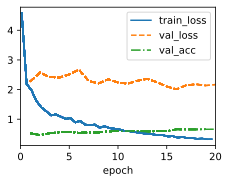

In [26]:
# Instantiate the MTFraEng data module with a batch size of 128.
data = MTFraEng(batch_size=128)

# Get a single batch of data from the training data loader.
# `src` is the source language sequence (e.g., French), `tgt` is the target language sequence (e.g., English),
# `src_valid_len` contains the valid lengths of the source sequences, and `label` contains the ground truth labels.
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))

# Find the maximum length of the source sequence in the batch (first sequence's length).
src_max_length = len(src[0])

# Set up model parameters
num_hiddens, num_blks, dropout = 256, 2, 0.2  # Hidden size, number of encoder/decoder blocks, dropout rate
ffn_num_hiddens, heads_num = 64, 4  # FFN hidden size, number of attention heads in multi-head attention

# Instantiate the encoder: TransformerEncoder processes the source sequence
encoder = TransformerEncoder(
    len(data.src_vocab), src_max_length, num_hiddens, num_blks, ffn_num_hiddens, heads_num, dropout)
    
# Instantiate the decoder: TransformerDecoder generates the target sequence
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, heads_num,
    num_blks, dropout)

# Instantiate the model using the encoder and decoder
# The padding token ID (`<pad>`) is passed to the model to handle padded tokens in the target sequences.
# The learning rate is set to 0.001.
model = Transformer(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)

# Instantiate the trainer with the following parameters:
# max_epochs = 30: Train the model for 30 epochs.
# gradient_clip_val = 1: Apply gradient clipping with a value of 1 to prevent exploding gradients.
# num_gpus = 1: Use 1 GPU for training.
trainer = Trainer(max_epochs=20, gradient_clip_val=1, num_gpus=1)

# Start the training process by calling `fit` on the trainer.
# The `fit` function will handle the entire training loop.
trainer.fit(model, data)


In [27]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU.

    Defined in :numref:`sec_seq2seq_training`"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [28]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

preds, _ = model.predict_step(
    data.build(engs, fras), try_gpu(), data.num_steps)

for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
